# Facial recognition via CNN

State-of-the-art image classification typically isn't done with traditional neural networks. Rather, it is performed with [convolutional neural networks](https://en.wikipedia.org/wiki/Convolutional_neural_network) (CNNs) that use [convolution layers](https://machinelearningmastery.com/convolutional-layers-for-deep-learning-neural-networks/) to extract features from images and [pooling layers](https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/) to downsize images so features can be detected at various resolutions. Let's use Keras to build a CNN and train it with the [Labeled Faces in the Wild](http://vis-www.cs.umass.edu/lfw/) to determine whether a CNN can be trained to perform facial recognition.

![](Images/cnn.png)

## Load the dataset

The first step is to import facial images from the dataset. LFW contains more than 13,000 facial images collected from the Web. Of the more than 5,000 people represented in the dataset, 1,680 have two or more facial images, while only five have 100 or more. We'll set the minimum number of faces per person to 100, which means that five sets of faces corresponding to five famous people will be imported. Each facial image is labeled with the name of the person that the face belongs to.

Unlike in previous examples in which we loaded 62x47 grayscale images, this time we will load full-resolution color images.

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_lfw_people

faces = fetch_lfw_people(min_faces_per_person=100, resize=1.0, color=True)
class_count = len(faces.target_names)

print(faces.target_names)
print(faces.images.shape)

['Colin Powell' 'Donald Rumsfeld' 'George W Bush' 'Gerhard Schroeder'
 'Tony Blair']
(1140, 125, 94, 3)


In total, 1,140 facial images were loaded. Each image measures 125 by 94 pixels. Use the following code to show the first 24 images in the dataset and the people to whom the faces belong.

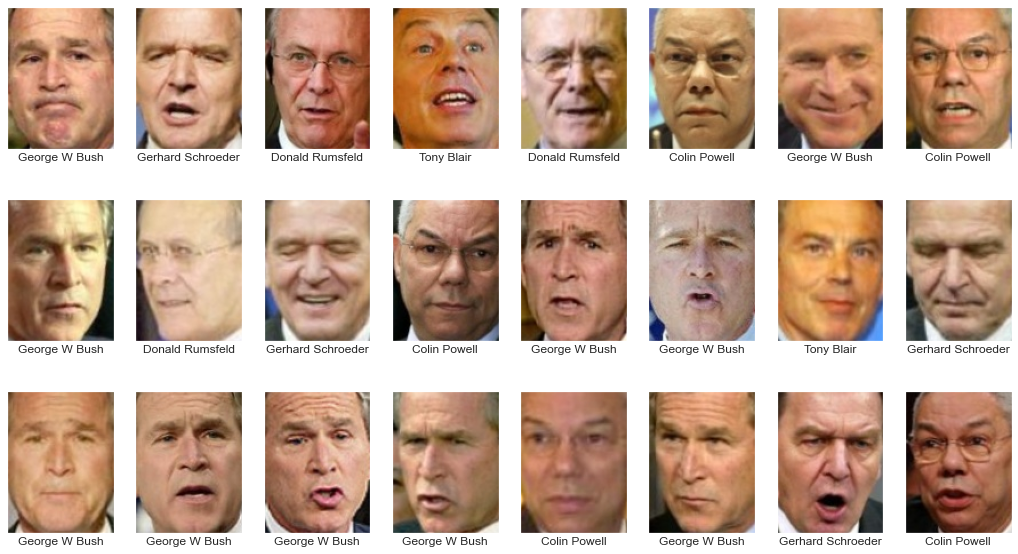

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

fig, ax = plt.subplots(3, 8, figsize=(18, 10))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i] / 255) # Reduce pixel values to 0.0 to 1.0 so Matplotlib doesn't clip everything above 1.0
    axi.set(xticks=[], yticks=[], xlabel=faces.target_names[faces.target[i]])

Check the balance in the dataset by generating a histogram showing how many facial images were imported for each of the five persons, or classes, that our neural network will try to predict.

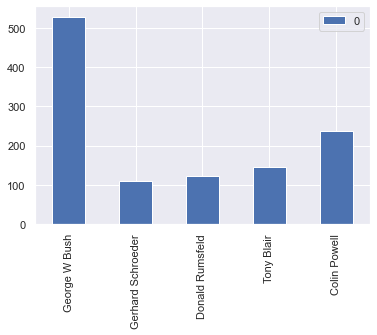

In [3]:
from collections import Counter
counts = Counter(faces.target)
names = {}

for key in counts.keys():
    names[faces.target_names[key]] = counts[key]

df = pd.DataFrame.from_dict(names, orient='index')
df.plot(kind='bar')

The dataset is not very well balanced, and that's a concern because classification models are best trained with balanced datasets. Use the following code to build a dataset containing 100 images of each person.

In [4]:
mask = np.zeros(faces.target.shape, dtype=np.bool)

for target in np.unique(faces.target):
    mask[np.where(faces.target == target)[0][:100]] = 1
    
x_faces = faces.images[mask]
y_faces = faces.target[mask]
x_faces.shape

(500, 125, 94, 3)

The next step is to preprocess the image data and convert the target values (the 0-based indices identifying the person that belongs to a face) into categorical values by [one-hot-encoding](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f) them. After that, we'll split the data for training and testing. Rather than allow Keras to do the splitting, we'll use Scikit-learn's `train_test_split` function.

In [5]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.applications.imagenet_utils import preprocess_input

face_images = preprocess_input(x_faces, mode='torch') # Scale pixel values to 0-1 and normalize using ImageNet data
face_labels = to_categorical(y_faces)

x_train, x_test, y_train, y_test = train_test_split(face_images, face_labels, train_size=0.8, stratify=face_labels, random_state=0)

Using TensorFlow backend.
C:\Users\Jeff\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


## Build and train a convolutional neural network

Build a CNN that contains three pairs of convolution and pooling layers followed by a classification layer containing 128 neurons and a `softmax` layer that outputs probabilities for each class and train it with LFW images.

In [6]:
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(face_images.shape[1:])))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(class_count, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 123, 92, 32)       896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 61, 46, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 59, 44, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 29, 22, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 27, 20, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 10, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8320)             

Now call `fit` to train the model.

In [7]:
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20, batch_size=25)

Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 4s 10ms/step - loss: 1.6695 - accuracy: 0.2125 - val_loss: 1.5881 - val_accuracy: 0.2400
Epoch 2/20
400/400 [==============================] - 4s 10ms/step - loss: 1.5056 - accuracy: 0.3900 - val_loss: 1.4095 - val_accuracy: 0.4300
Epoch 3/20
400/400 [==============================] - 4s 10ms/step - loss: 1.0882 - accuracy: 0.5750 - val_loss: 1.1101 - val_accuracy: 0.5600
Epoch 4/20
400/400 [==============================] - 4s 10ms/step - loss: 0.6444 - accuracy: 0.7700 - val_loss: 0.9642 - val_accuracy: 0.6700
Epoch 5/20
400/400 [==============================] - 4s 10ms/step - loss: 0.3646 - accuracy: 0.8775 - val_loss: 0.9143 - val_accuracy: 0.6900
Epoch 6/20
400/400 [==============================] - 4s 10ms/step - loss: 0.2125 - accuracy: 0.9275 - val_loss: 0.7467 - val_accuracy: 0.8000
Epoch 7/20
400/400 [==============================] - 4s 9ms/step - loss: 0.0710 - accuracy: 0.9

With training complete, plot the training and validation accuracy to see how well the network performed.

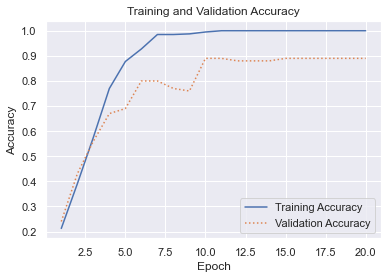

In [8]:
def show_history(hist):
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, '-', label='Training Accuracy')
    plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.plot()
    
show_history(hist)

Run some test data through the network and use a confusion matrix to see how it fared.

Text(89.18, 0.5, 'Predicted label')

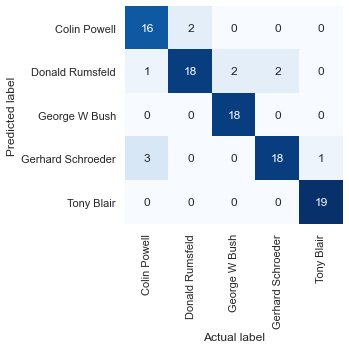

In [9]:
from sklearn.metrics import confusion_matrix

y_predicted = model.predict(x_test)
mat = confusion_matrix(y_test.argmax(axis=1), y_predicted.argmax(axis=1))

sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)

plt.xlabel('Actual label')
plt.ylabel('Predicted label')

How many times did the network correctly identify George W. Bush? How many times did it fail to identify him?

## Make a prediction

Load a picture of George W. Bush downloaded from the Internet that has been cropped to approximately match the training images and use the network to make a prediction. The first step is to load the image and size it to the dimensions that the network expects.

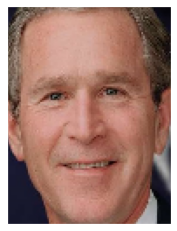

In [10]:
from keras.preprocessing import image

x = image.load_img('Data/george.jpg', target_size=(face_images.shape[1:3]))
plt.xticks([])
plt.yticks([])
plt.imshow(x)

Now see if the CNN can identify the person in the picture.

In [11]:
x = image.img_to_array(x)
x = preprocess_input(x, mode='torch')
x = np.expand_dims(x, axis=0)
y = model.predict(x)[0]

for i in range(len(y)):
    print(faces.target_names[i] + ': ' + str(y[i]))

Colin Powell: 0.99052304
Donald Rumsfeld: 8.869241e-05
George W Bush: 0.0005534341
Gerhard Schroeder: 0.0015499439
Tony Blair: 0.0072848764


Did it correctly identify the face as that of George W. Bush?